<a href="https://colab.research.google.com/github/nikhilchilukoti/Cars_App/blob/master/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Connecting with Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## **Following functions are used for Dataset Loading**

In [ ]:
import pickle
import numpy as np
import os
import platform


def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

## **KNN algorithm in numpy**

In [ ]:
import numpy as np

class KNearestNeighbor(object):
    def __init__(self):
        pass
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        t1 = np.sum(np.square(self.X_train), axis=1)
        t2 = np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T)    
        dists = np.sqrt(t1 + t2)
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:k]])
            pass
            y_pred[i]= (np.argmax(np.bincount(closest_y)))
            pass
        return y_pred

## **K-means algorithm in numpy**

In [ ]:
class KMeans():
    def __init__(self, n_cluster, max_iter=100, e=0.0001):
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.e = e

    def fit(self, x):
        np.random.seed(42)
        N, D = x.shape
        J = 1e10
        random_ind = np.random.choice(N,self.n_cluster)
        means = x[random_ind,:]

        def compute_square_distances(Xtrain, X):
            num_train = Xtrain.shape[0]
            num_test =  X.shape[0]
            Xsq = np.sum(np.square(X),axis=1)
            Xsq = Xsq.reshape(num_test,1)
            Xtrsq = np.sum(np.square(Xtrain),axis=1)
            Xtrsq = Xtrsq.reshape(1,num_train)
            dot = np.dot(X,Xtrain.T)
            dists = Xsq - 2*dot + Xtrsq
            return dists

        for iteration in range(self.max_iter):
            square_dist = compute_square_distances(x, means)
            membership = np.argmin(square_dist,axis=0)
            r = np.zeros((self.n_cluster, N))
            r[membership,np.arange(N)] = 1
            J_new = np.mean(np.sum(r * square_dist, axis=0))
            if np.absolute(J - J_new) <= self.e:
                break
            J = J_new
            means = np.dot(r,x) / np.sum(r,axis=1,keepdims = True)

        return (means, membership, iteration+1)

class KMeansClassifier():

    def __init__(self, n_cluster, max_iter=100, e=1e-6):
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.e = e

    def fit(self, x, y):
        np.random.seed(42)
        N, D = x.shape
        kmeans = KMeans(self.n_cluster, self.max_iter, self.e)
        centroids, membership, _ = kmeans.fit(x)
        r = np.zeros((self.n_cluster, N))
        r[membership,np.arange(N)] = 1
        label_matrix = r * (y+1).reshape(1,-1)
        centroid_labels = []
        for k in range(self.n_cluster):
            to_choose = label_matrix[k,:]
            mask = to_choose >0
            cluster_labels = to_choose[mask]
            (_, idx, counts) = np.unique(cluster_labels, return_index=True, return_counts=True)
            index = idx[np.argmax(counts)]
            centroid_labels.append(cluster_labels[index])
        centroid_labels = np.array(centroid_labels) - 1 
        self.centroid_labels = centroid_labels
        self.centroids = centroids

    def predict(self, x):
        np.random.seed(42)
        N, D = x.shape
        def compute_square_distances(Xtrain, X):
            num_train = Xtrain.shape[0]
            num_test =  X.shape[0]
            Xsq = np.sum(np.square(X),axis=1)
            Xsq = Xsq.reshape(num_test,1)
            Xtrsq = np.sum(np.square(Xtrain),axis=1)
            Xtrsq = Xtrsq.reshape(1,num_train)
            dot = np.dot(X,Xtrain.T)
            dists = Xsq - 2*dot + Xtrsq
            return dists

        dists = compute_square_distances(x,self.centroids)
        membership = np.argmin(dists,axis=0)
        labels = self.centroid_labels[membership]
        return labels

## **Softmax Classifier algorithm in scratch Numpy**

In [ ]:
import random
class Softmax:
    __slots__ = ("epochs", "learningRate", "batchSize", "regStrength", "wt", "momentum", "velocity")
    def __init__(self, epochs, learningRate, batchSize, regStrength, momentum):
        self.epochs = epochs
        self.learningRate = learningRate
        self.batchSize = batchSize
        self.regStrength = regStrength
        self.momentum = momentum
        self.velocity = None
        self.wt = None

    def train(self, xTrain, yTrain, xTest, yTest):
        D = xTrain.shape[1]  # dimensionality
        label = np.unique(yTrain)
        numOfClasses = len(label) # number of classes
        yTrainEnc = self.oneHotEncoding(yTrain, numOfClasses)
        yTestEnc = self.oneHotEncoding(yTest, numOfClasses)
        self.wt = 0.001 * np.random.rand(D, numOfClasses)
        self.velocity = np.zeros(self.wt.shape)
        trainLosses = []
        testLosses = []
        trainAcc = []
        testAcc = []
        for e in range(self.epochs): # loop over epochs
            trainLoss = self.SGDWithMomentum(xTrain, yTrainEnc)
            testLoss, dw = self.computeLoss(xTest, yTestEnc)
            trainAcc.append(self.meanAccuracy(xTrain, yTrain))
            testAcc.append(self.meanAccuracy(xTest, yTest))
            trainLosses.append(trainLoss)
            testLosses.append(testLoss)
            print("{:d}\t->\tTrainL : {:.7f}\t|\tTestL : {:.7f}\t|\tTrainAcc : {:.7f}\t|\tTestAcc: {:.7f}"
                  .format(e, trainLoss, testLoss, trainAcc[-1], testAcc[-1]))
        return trainLosses, testLosses, trainAcc, testAcc

    def SGDWithMomentum(self, x, y):
        losses = []
        randomIndices = random.sample(range(x.shape[0]), x.shape[0])
        x = x[randomIndices]
        y = y[randomIndices]
        for i in range(0, x.shape[0], self.batchSize):
            Xbatch = x[i:i+self.batchSize]
            ybatch = y[i:i+self.batchSize]
            loss, dw = self.computeLoss(Xbatch, ybatch)
            self.velocity = (self.momentum * self.velocity) + (self.learningRate * dw)
            self.wt -= self.velocity
            losses.append(loss)
        return np.sum(losses) / len(losses)

    def softmaxEquation(self, scores):
        scores -= np.max(scores)
        prob = (np.exp(scores).T / np.sum(np.exp(scores), axis=1)).T
        return prob

    def computeLoss(self, x, yMatrix):
        numOfSamples = x.shape[0]
        scores = np.dot(x, self.wt)
        prob = self.softmaxEquation(scores)

        loss = -np.log(np.max(prob)) * yMatrix
        regLoss = (1/2)*self.regStrength*np.sum(self.wt*self.wt)
        totalLoss = (np.sum(loss) / numOfSamples) + regLoss
        grad = ((-1 / numOfSamples) * np.dot(x.T, (yMatrix - prob))) + (self.regStrength * self.wt)
        return totalLoss, grad

    def meanAccuracy(self, x, y):
        predY = self.predict(x)
        predY = predY.reshape((-1, 1))
        return np.mean(np.equal(y, predY))

    def predict(self, x):
        return np.argmax(x.dot(self.wt), 1)

    def oneHotEncoding(self, y, numOfClasses):
        y = np.asarray(y, dtype='int32')
        if len(y) > 1:
            y = y.reshape(-1)
        if not numOfClasses:
            numOfClasses = np.max(y) + 1
        yMatrix = np.zeros((len(y), numOfClasses))
        yMatrix[np.arange(len(y)), y] = 1
        return yMatrix

## **Loading dataset fom google drive**

In [ ]:
cifar10_dir = './cifar-10-batches-py'#'/gdrive/MyDrive/data/cifar-10-python/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## **Training KNN clasiifier with K=1**

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists= classifier.compute_distances(X_test)
y_test_pred = classifier.predict_labels(dists, k=1)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / 10000
print('Got %d / %d correct => accuracy: %f' % (num_correct, 10000, accuracy))

(50000, 3072) (10000, 3072)
Got 3539 / 10000 correct => accuracy: 0.353900


## **Cross validition with 5 folds of KNN with K values of 3,5,7 and 11**

In [ ]:
num_test = 10000
num_folds = 5
k_choices = [3,5,7,11]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
k_to_accuracies = {}

for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0,num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds
        
        temp = np.delete(X_train,num_knn,0)
        X_train = np.concatenate((temp),axis = 0)
        y_train = np.delete(y_train,num_knn,0)
        y_train = np.concatenate((y_train),axis = 0)
        
        classifier = KNearestNeighbor()
        classifier.train(X_train, y_train)
        dists = classifier.compute_distances(X_test)
        y_test_pred = classifier.predict_labels(dists, k)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / num_test
#         print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[k].append(accuracy)

print("Printing our 5-fold accuracies for varying values of k:")
print()
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

Printing our 5-fold accuracies for varying values of k:

k = 3, accuracy = 0.326000
k = 3, accuracy = 0.326100
k = 3, accuracy = 0.328000
k = 3, accuracy = 0.325200
k = 3, accuracy = 0.317800
k = 5, accuracy = 0.335000
k = 5, accuracy = 0.329700
k = 5, accuracy = 0.333600
k = 5, accuracy = 0.334000
k = 5, accuracy = 0.328300
k = 7, accuracy = 0.340000
k = 7, accuracy = 0.333000
k = 7, accuracy = 0.335600
k = 7, accuracy = 0.331000
k = 7, accuracy = 0.323700
k = 11, accuracy = 0.338100
k = 11, accuracy = 0.324300
k = 11, accuracy = 0.330700
k = 11, accuracy = 0.330700
k = 11, accuracy = 0.323200


## **Training Kmeans with k=2**

In [ ]:
num_test = 10000
n_cluster = 2
classifier = KMeansClassifier(n_cluster=n_cluster, max_iter=100, e=1e-6)

classifier.fit(X_train, y_train)
y_hat_test = classifier.predict(X_test)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 2347 / 10000 correct => accuracy: 0.234700


In [ ]:
num_folds = 5
k_choices = [3,5,7,11]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
k_to_accuracies = {}

for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0,num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds
        
        temp = np.delete(X_train,num_knn,0)
        X_train = np.concatenate((temp),axis = 0)
        y_train = np.delete(y_train,num_knn,0)
        y_train = np.concatenate((y_train),axis = 0)
        
        classifier = KMeansClassifier(n_cluster=k, max_iter=100, e=1e-6)
        classifier.fit(X_train, y_train)
        y_test_pred = classifier.predict(X_test)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / num_test
#         print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[k].append(accuracy)

print("Printing our 5-fold accuracies for varying values of k:")
print()
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

Printing our 5-fold accuracies for varying values of k:

k = 3, accuracy = 0.183000
k = 3, accuracy = 0.170400
k = 3, accuracy = 0.179700
k = 3, accuracy = 0.172500
k = 3, accuracy = 0.178600
k = 5, accuracy = 0.194300
k = 5, accuracy = 0.181700
k = 5, accuracy = 0.187900
k = 5, accuracy = 0.185400
k = 5, accuracy = 0.192000
k = 7, accuracy = 0.202100
k = 7, accuracy = 0.188500
k = 7, accuracy = 0.194700
k = 7, accuracy = 0.191100
k = 7, accuracy = 0.198800
k = 11, accuracy = 0.233400
k = 11, accuracy = 0.226400
k = 11, accuracy = 0.238300
k = 11, accuracy = 0.223800
k = 11, accuracy = 0.234700


## **Training softmax classifier**

In [ ]:
epochs = 10
learningRate = 0.001
batchSize = 1
regStrength = 0.001
momentum =0.05
sm = Softmax(epochs=epochs, learningRate=learningRate, batchSize=batchSize,
                 regStrength=regStrength, momentum=momentum)
trainLosses, testLosses, trainAcc, testAcc = sm.train(X_train, y_train, X_test, y_test) # Train a network


/tmp/ipykernel_242250/709730193.py:52: RuntimeWarning: invalid value encountered in true_divide
  prob = (np.exp(scores).T / np.sum(np.exp(scores), axis=1)).T


0	->	TrainL : 65.8428338	|	TestL : nan	|	TrainAcc : 0.1000000	|	TestAcc: 0.1000000
1	->	TrainL : 146.2277968	|	TestL : nan	|	TrainAcc : 0.1000000	|	TestAcc: 0.1000000
2	->	TrainL : 202.7587520	|	TestL : nan	|	TrainAcc : 0.1000000	|	TestAcc: 0.1000000
3	->	TrainL : 253.9546283	|	TestL : nan	|	TrainAcc : 0.1000000	|	TestAcc: 0.1000000
4	->	TrainL : 299.7831397	|	TestL : nan	|	TrainAcc : 0.1000000	|	TestAcc: 0.1000000
5	->	TrainL : 342.5447429	|	TestL : nan	|	TrainAcc : 0.1000000	|	TestAcc: 0.1000000
6	->	TrainL : 379.0513859	|	TestL : nan	|	TrainAcc : 0.1000000	|	TestAcc: 0.1000000
7	->	TrainL : 413.9432071	|	TestL : nan	|	TrainAcc : 0.1000000	|	TestAcc: 0.1000000
8	->	TrainL : 443.1525810	|	TestL : nan	|	TrainAcc : 0.1000000	|	TestAcc: 0.1000000
9	->	TrainL : 473.3564177	|	TestL : nan	|	TrainAcc : 0.1000000	|	TestAcc: 0.1000000


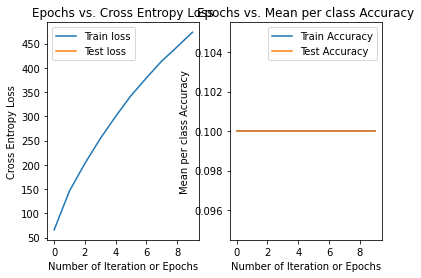

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.plot(trainLosses, label="Train loss")
plt.plot(testLosses, label="Test loss")
plt.legend(loc='best')
plt.title("Epochs vs. Cross Entropy Loss")
plt.xlabel("Number of Iteration or Epochs")
plt.ylabel("Cross Entropy Loss")

plt.subplot(1, 2, 2)
plt.plot(trainAcc, label="Train Accuracy")
plt.plot(testAcc, label="Test Accuracy")
plt.legend(loc='best')
plt.title("Epochs vs. Mean per class Accuracy")
plt.xlabel("Number of Iteration or Epochs")
plt.ylabel("Mean per class Accuracy")
plt.show()
